### Binary Intrusion Detection — Model Training & Comparison

This notebook performs binary classification (Attack vs Benign) on the engineered CIC-IIoT dataset `combined_engineered_features.csv`.
Primary objective: train K-Nearest Neighbors (KNN).  
Extended objective: train and compare multiple classifiers (KNN, Random Forest, SVM, Logistic Regression) with hyperparameter tuning, compute full set of metrics, plot ROC & confusion matrices, save best models and metric summary.

**Notes:**
- Input dataset path: `data/features/combined_engineered_features.csv`
- Output models saved to: `data/models/`
- Metric summary saved to: `data/models/metrics_summary.csv`

#### Imports & Config

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix
)
import joblib
sns.set(style="whitegrid")
%matplotlib inline

# Paths
FEATURE_PATH = os.path.join("data", "features", "combined_engineered_features.csv")
MODELS_DIR = os.path.join("data", "models")
os.makedirs(MODELS_DIR, exist_ok=True)

#### Load & Prepare

In [2]:
# Cell: load data
df = pd.read_csv(FEATURE_PATH)
print("Loaded dataset:", df.shape)

# Ensure label1 exists
assert "label1" in df.columns, "label1 column not found in dataset!"

# Prepare features and binary target
X = df.drop(columns=["label1","label2","label3","label4","label_full"], errors='ignore')
y = df["label1"].apply(lambda x: 1 if str(x).lower() == "attack" else 0)

print("Feature matrix shape:", X.shape)
print("Class distribution:\n", y.value_counts().rename({0:"Benign",1:"Attack"}))


Loaded dataset: (685671, 45)
Feature matrix shape: (685671, 40)
Class distribution:
 label1
Benign    400672
Attack    284999
Name: count, dtype: int64


#### Train/Test Split

In [3]:
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (548536, 40) Test shape: (137135, 40)


#### Evaluate model (metrics + plots)

In [4]:
# Cell: helper functions
def compute_metrics(y_true, y_pred, y_prob=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)  # sensitivity
    f1 = f1_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    roc_auc = roc_auc_score(y_true, y_prob) if (y_prob is not None) else np.nan
    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "specificity": spec,
        "f1": f1,
        "roc_auc": roc_auc,
        "confusion_matrix": cm
    }

def plot_confusion(cm, labels=["Benign","Attack"], title="Confusion Matrix"):
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def plot_roc(y_true, y_prob, label):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f})")
    return auc


#### Define Models + Parameter Grids

In [5]:
model_defs = {}

# KNN
model_defs["knn"] = {
    "estimator": KNeighborsClassifier(),
    "param_grid": {
        "n_neighbors": [3,5,7,9,11],
        "weights": ["uniform","distance"],
        "metric": ["euclidean","manhattan","minkowski"]
    }
}

#### Training loop (RandomizedSearchCV per model) and evaluation


=== Running model: KNN (Randomized Search) ===
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best params: {'weights': 'distance', 'n_neighbors': 7, 'metric': 'manhattan'}
Best CV f1: 0.9503718292681381
 Saved best model to: data\models\knn_binary_model.pkl

Confusion Matrix:


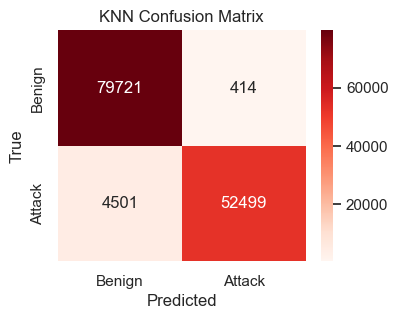


ROC Curve:


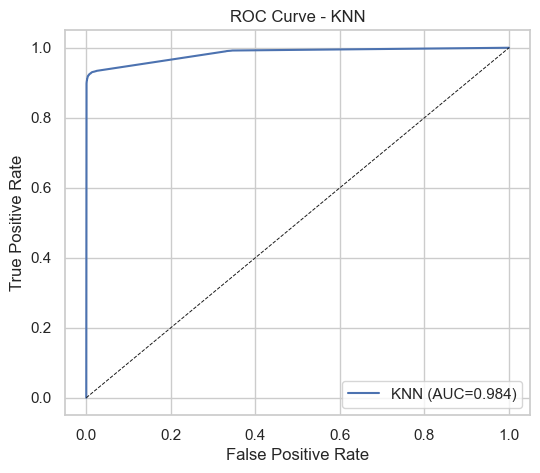

In [6]:
results = []
MODELS_TO_RUN = ["knn"]  
CV = 3

for key in MODELS_TO_RUN:
    print(f"\n=== Running model: {key.upper()} (Randomized Search) ===")
    spec = model_defs[key]
    estimator = spec["estimator"]
    param_grid = spec["param_grid"]

    # Randomized Search with StratifiedKFold
    cv = StratifiedKFold(n_splits=CV, shuffle=True, random_state=RANDOM_STATE)
    search = RandomizedSearchCV(
        estimator,
        param_distributions=param_grid,
        n_iter=3,           
        scoring="f1",
        cv=cv,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=2
    )
    search.fit(X_train, y_train)

    best = search.best_estimator_
    print("Best params:", search.best_params_)
    print("Best CV f1:", search.best_score_)

    # Predict
    y_pred = best.predict(X_test)
    y_prob = best.predict_proba(X_test)[:,1] if hasattr(best, "predict_proba") else best.decision_function(X_test)

    # Compute metrics
    metrics = compute_metrics(y_test, y_pred, y_prob)
    results.append({
        "model": key,
        "best_params": search.best_params_,
        "cv_f1": search.best_score_,
        "test_accuracy": metrics["accuracy"],
        "test_precision": metrics["precision"],
        "test_recall": metrics["recall"],
        "test_specificity": metrics["specificity"],
        "test_f1": metrics["f1"],
        "test_roc_auc": metrics["roc_auc"]
    })

    # Save model
    model_file = os.path.join(MODELS_DIR, f"{key}_binary_model.pkl")
    joblib.dump(best, model_file)
    print(f" Saved best model to: {model_file}")

    # Visualization
    print("\nConfusion Matrix:")
    plot_confusion(metrics["confusion_matrix"], title=f"{key.upper()} Confusion Matrix")

    print("\nROC Curve:")
    plt.figure(figsize=(6,5))
    plot_roc(y_test, y_prob, label=key.upper())
    plt.plot([0,1],[0,1],"k--", linewidth=0.7)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {key.upper()}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

#### Summary table & save CSV

In [8]:
metrics_df = pd.DataFrame(results)
metrics_csv = os.path.join(MODELS_DIR, "metrics_summary_binary.csv")
metrics_df.to_csv(metrics_csv, index=False)
print("Saved metrics summary to:", metrics_csv)
metrics_df.style.format({
    "cv_f1":"{:.4f}",
    "test_accuracy":"{:.4f}",
    "test_precision":"{:.4f}",
    "test_recall":"{:.4f}",
    "test_specificity":"{:.4f}",
    "test_f1":"{:.4f}",
    "test_roc_auc":"{:.4f}"
})

Saved metrics summary to: data\models\metrics_summary_binary.csv


,model,best_params,cv_f1,test_accuracy,test_precision,test_recall,test_specificity,test_f1,test_roc_auc
0,knn,"{'weights': 'distance', 'n_neighbors': 7, 'metric': 'manhattan'}",0.9504,0.9642,0.9922,0.9210,0.9948,0.9553,0.9836
